In [9]:
import pandas as pd


cleanedData = pd.read_csv('train_transformed.csv')
#cleanedData.info()
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Prevent line breaks
#
#print(cleanedData.head())
#print the first 20 values 
print(cleanedData.head(20))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85763 entries, 0 to 85762
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_ID               85763 non-null  object 
 1   Age                       85763 non-null  float64
 2   Annual_Income             85763 non-null  float64
 3   Monthly_Inhand_Salary     85763 non-null  float64
 4   Num_Bank_Accounts         85763 non-null  float64
 5   Num_Credit_Card           85763 non-null  float64
 6   Interest_Rate             85763 non-null  float64
 7   Num_of_Loan               85763 non-null  float64
 8   Delay_from_due_date       85763 non-null  float64
 9   Num_of_Delayed_Payment    85763 non-null  float64
 10  Changed_Credit_Limit      85763 non-null  float64
 11  Num_Credit_Inquiries      85763 non-null  float64
 12  Credit_Mix                85763 non-null  int64  
 13  Outstanding_Debt          85763 non-null  float64
 14  Credit

In [5]:
# lets load the data from train.csv and test.csv files
import pandas as pd
import numpy as np

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

C:\Users\kb\AppData\Local\Temp\ipykernel_42336\1803201993.py:5: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('train.csv')


In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class NumericCleaner(BaseEstimator, TransformerMixin):
   def __init__(self):
      self.columns_to_clean =  ['Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment',
       'Changed_Credit_Limit', 'Outstanding_Debt', 'Amount_invested_monthly', 'Monthly_Balance']

   def fit(self, X, y=None):
      # No fitting necessary for this transformer
      return self

   def transform(self, X):
      print('Cleaning numeric columns')
      # Make a copy of the DataFrame to avoid modifying the original data
      X = X.copy()
            
      # Apply cleaning function to each specified column
      for column in self.columns_to_clean:
         X[column] = pd.to_numeric(X[column].str.replace(r'[^0-9.-]', '', regex=True), errors='coerce')

        
      return X

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.validation import check_is_fitted
import pandas as pd

class CreditHistoryTransformer(BaseEstimator, TransformerMixin):
   def __init__(self):
      self.column = 'Credit_History_Age'
        

   def fit(self, X, y=None): 
      assert isinstance(X, pd.DataFrame) and self.column in X.columns
      #set number of features
      self._n_features = X.shape[1]
      return self
   
   def transform(self, X):
      check_is_fitted(self, '_n_features')
      assert isinstance(X, pd.DataFrame) and self.column in X.columns   
      print('Transforming Credit_History_Age')
      #now lets transformt the data 
      # we need to convert the verbal description to numerical values
      # it's in this form '22 Years and 1 Months'
      # first we change the column to string type 
      #tthen process the string to get the numerical values
      # then multiply the years by 12 and add the months
      X[self.column] = X[self.column].astype(str)

      years = X[self.column].str.extract(r'(\d+)\s*Years?')[0].fillna(0).astype(int)
      months = X[self.column].str.extract(r'(\d+)\s*Months?')[0].fillna(0).astype(int)

    # Calculate total months
      X[self.column] = years * 12 + months
      return X

      

In [4]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.validation import check_is_fitted
import pandas as pd

class PaymentBehaviourTransformer(BaseEstimator, TransformerMixin):
   def __init__(self):
      self.charge_mapping = {'Low_spent': 0, 'Medium_spent': 1, 'High_spent': 2}
      self.payment_mapping = {'Small_value_payments': 0, 'Medium_value_payments': 1, 'Large_value_payments': 2}
      self.columns = 'Payment_Behaviour'

   def fit(self, X, y=None):
      assert isinstance(X, pd.DataFrame)
      'Payment_Behaviour' in X.columns

      return self
   
   def transform(self, X):
      charge, payment = X['Payment_Behaviour'].apply(self.split_payment_behavior)
      X['Charge'] = charge
      X['Payment'] = payment
      X.drop('Payment_Behaviour', axis=1, inplace=True)
      print('Transforming Payment_Behaviour')
      return X
   
   def split_payment_behavior(self, value):
      if isinstance(value, str):
         # Split the value into components based on the underscore
         parts = value.split('_')
         
         # The first part corresponds to charge, and the last two parts correspond to payment
         charge_part = '_'.join(parts[:2])  # Join the first two parts for charge
         payment_part = '_'.join(parts[2:])  # Join the rest for payment
         
         # Get the corresponding numerical values from the mappings
         charge_value = self.charge_mapping.get(charge_part, np.nan)
         payment_value = self.payment_mapping.get(payment_part, np.nan)
         
         return pd.Series([charge_value, payment_value])
      else:
         return pd.Series([np.nan, np.nan])  # Return NaN for non-string values

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.validation import check_is_fitted
import pandas as pd

class LoanType(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ml_binarizer = MultiLabelBinarizer()

    def fit(self, X, y=None):
        assert isinstance(X, pd.DataFrame) and 'Type_of_Loan' in X.columns
        # Ensure the column is treated as a string and handle NaN values
        loan_types = X['Type_of_Loan'].fillna('Not Specified').astype(str).str.split(', ')
        # Clean up the loan types to remove unwanted phrases
        loan_types = loan_types.apply(lambda x: [item.strip() for item in x if 'and' not in item])
        self.ml_binarizer.fit(loan_types)      
        self._n_features = len(self.ml_binarizer.classes_)
        return self 

    def transform(self, X):
        # Check if the transformer has been fitted\
        print('Transforming Loan Type')
        check_is_fitted(self, '_n_features')
        assert isinstance(X, pd.DataFrame) and 'Type_of_Loan' in X.columns
        # Ensure the column is treated as a string and handle NaN values
        loan_types = X['Type_of_Loan'].fillna('Not Specified').astype(str).str.split(', ')
        # Clean up the loan types to remove unwanted phrases
        loan_types = loan_types.apply(lambda x: [item.strip() for item in x if 'and' not in item])
        loan_type_dummies = self.ml_binarizer.transform(loan_types)
        
        # Create a DataFrame for the binary columns
        loan_type_df = pd.DataFrame(loan_type_dummies, columns=self.ml_binarizer.classes_, index=X.index)
        
        # Concatenate the new binary columns with the original DataFrame
        X = pd.concat([X, loan_type_df], axis=1)
        X.drop('Type_of_Loan', axis=1, inplace=True)
        return X

In [6]:
from numpy import NAN
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

class HiLoImputer(BaseEstimator, TransformerMixin):
    def __init__(self, lo, hi, columnName):
        self.hi = hi
        self.lo = lo
        self.columnName = columnName
        self.isCategory = False

    def fit(self, X, y=None):
        assert isinstance(X, pd.DataFrame) and len(X.columns) > 1
        assert self.columnName in X.columns
        
        # Check if the column is categorical
        self.isCategory = X[self.columnName].dtype.name == 'object' or X[self.columnName].dtype.name == 'category'
        if self.isCategory:
            #convert to category

            self.categories_ = X[self.columnName].astype('category').cat.categories

        # Store the number of features
        self._n_features = X.shape[1]
        return self

    def transform(self, X):
        check_is_fitted(self, '_n_features')
        assert isinstance(X, pd.DataFrame) and X.shape[1] == self._n_features
        print('Imputing HiLo values')

        if self.isCategory:
            # Convert categories to codes for hi/lo processing
            X[self.columnName] = X[self.columnName].astype('category').cat.codes

            # Apply hi/lo bounds, setting out-of-bounds to NaN
            X[self.columnName] = np.where(
                (X[self.columnName] > self.hi) | (X[self.columnName] < self.lo), 
                np.nan, X[self.columnName]
            )
            
            # Replace NaN values with the mode per Customer_ID group
            X[self.columnName] = X.groupby('Customer_ID', group_keys=False)[self.columnName].apply(
                lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x)
            )

            # Convert back to categories
            X[self.columnName] = pd.Categorical.from_codes(
                X[self.columnName].fillna(-1).astype(int), categories=self.categories_, ordered=True
            ).remove_unused_categories()

        else:
            # Apply hi/lo bounds for numerical data
            X[self.columnName] = np.where(
                (X[self.columnName] > self.hi) | (X[self.columnName] < self.lo), 
                np.nan, X[self.columnName]
            )

            # Replace NaN values with the mode per Customer_ID group
            X[self.columnName] = X.groupby('Customer_ID', group_keys=False)[self.columnName].apply(
                lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x)
            )

        return X


In [7]:
class toCategoryCodes(BaseEstimator, TransformerMixin):
    def __init__(self):
       pass
      

    def fit(self, X, y=None):
        assert isinstance(X, pd.DataFrame) and len(X.columns) > 1
       # assert self.columnName in X.columns
       # lets get the categorical columns
        self.columnName = X.select_dtypes(include=['object', 'category']).columns

        # Store the number of features
        self._n_features = X.shape[1]
        return self

    def transform(self, X):
        check_is_fitted(self, '_n_features')
        assert isinstance(X, pd.DataFrame) and X.shape[1] == self._n_features
        print('Converting to category')
        for column in self.columnName:
            #convert to cat codes
            X[column] = X[column].astype('category').cat.codes
            
         #X[self.columnName] = X[self.columnName].astype('category')
        return X

In [8]:
class HiLoTransformer(BaseEstimator, TransformerMixin):
   def __init__(self, bounds):
      self.bounds = bounds 
      
   
   def fit(self, X):
      assert isinstance(X, pd.DataFrame)
      self._n_features = X.shape[1]
      self._feature_names = X.columns
 
      return self
   
   def transform(self, X):
      check_is_fitted(self, '_n_features')
      assert isinstance(X, pd.DataFrame) and X.shape[1] == self._n_features
      print('Transforming HiLo values')
      
      for column, bounds in self.bounds.items():
         isCategory = X[column].dtype.name == 'category' or X[column].dtype.name == 'object'
  
         if  X[column].dtype.name == 'category' or X[column].dtype.name == 'object':
            X[column] = X[column].astype('category')

            categories = X[column].cat.categories
            X[column] = X[column].astype('category').cat.codes

         X[column] = np.where(
               (X[column] > bounds['hi']) | (X[column] < bounds['lo']), 
               np.nan, X[column]
         )
         X[column] = X.groupby('Customer_ID', group_keys=False)[column].apply(
               lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x)
         )
         #convert back to categorical
         if isCategory:
            X[column] = pd.Categorical.from_codes(
               X[column].fillna(-1).astype(int), categories=categories, ordered=True
            ).remove_unused_categories()
            X[column] = X[column].astype('category')
            print(X[column].value_counts())

      return X

   def get_feature_names_out(self, input_features=None):
      if input_features is None:
         return self._feature_names
      return input_features

In [9]:
from sklearn.preprocessing import OneHotEncoder


class OccupationOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.onehot = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        print('OccupationOneHotEncoder')
    
    def fit(self, X, y=None):
        # Handle missing data by filling it with a placeholder
        
      #  X['Occupation'] = X['Occupation'].astype(str)
        self.onehot.fit(X[['Occupation']])
        self.feature_names_out = self.onehot.get_feature_names_out(['Occupation'])
        return self
    
    def transform(self, X):
        encoded = self.onehot.transform(X[['Occupation']])
        encoded_df = pd.DataFrame(encoded, columns=self.onehot.get_feature_names_out(['Occupation']))
        X = X.reset_index(drop=True)
        return pd.concat([X, encoded_df], axis=1).drop(columns=['Occupation'])

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return self.feature_names_out
        return input_features

In [10]:

class DropColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        self.feature_names_out_ = [col for col in X.columns if col not in self.columns]
        return self
    
    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            # Use default column names if X is a numpy array
            print('Transforming DropColumns')
            X = pd.DataFrame(X)

        X.drop(columns=self.columns, inplace=True, errors='ignore')
        X.info()
        return X
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_out_

In [11]:
hi_lo_bounds = {
    # Numerical Columns
    'Age': {'lo': 0, 'hi': 100},
    'Annual_Income': {'lo': 5000, 'hi': 500000},
    'Monthly_Inhand_Salary': {'lo': 500, 'hi': 30000},
    'Num_Bank_Accounts': {'lo': 0, 'hi': 20},
    'Num_Credit_Card': {'lo': 0, 'hi': 15},
    'Interest_Rate': {'lo': 0, 'hi': 50},
    'Delay_from_due_date': {'lo': 0, 'hi': 100},
    'Num_Credit_Inquiries': {'lo': 0, 'hi': 30},
    'Changed_Credit_Limit': {'lo': 0, 'hi': 30},  # Bounds after converting to numeric
    'Num_of_Loan': {'lo': 0, 'hi': 10},  # Bounds after converting to numeric
    
    # Categorical Columns (ordered)
    'Credit_Mix': {'lo': 0, 'hi': 2},  # Assuming "Bad" = 0, "Standard" = 1, "Good" = 2

    # Categorical Column (nominal)
    'Occupation': {'lo': 0, 'hi': 14}  # No bounds, only impute missing values
}


In [12]:
#transformer to drop Nan rows
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class DropNanRows(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        print('Dropping Nan rows')
        return X.dropna()

In [13]:
# lets make a month transformer
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class MonthTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        print('Transforming Month')
        X['Month'] = X['Month'].astype('category').cat.codes
        X['Month_sin'] = np.sin(2 * np.pi * X['Month'] + 1 / 12)
        X['Month_cos'] = np.cos(2 * np.pi * X['Month'] + 1 / 12)
        X.drop(columns=['Month'], inplace=True)
        return X    

In [14]:
from sklearn.pipeline import Pipeline


pipeline = Pipeline(steps= [
   ('NumericCleaner', NumericCleaner()),
   
   ('CreditHistoryTransformer', CreditHistoryTransformer()),
   ('PaymentBehaviourTransformer', PaymentBehaviourTransformer()),
   ('LoanType', LoanType()),
   ('HiLoTransformer', HiLoTransformer(bounds=hi_lo_bounds)), 
   ('OccupationOneHotEncoder', OccupationOneHotEncoder()),
   ('DropColumnsTransformer', DropColumnsTransformer(columns=['Customer_ID', 'ID', 'Name', 'SSN'])),
    
   ('toCategoryCodes', toCategoryCodes()),('MonthTransformer', MonthTransformer()),
    ('DropNanRows', DropNanRows())
])


OccupationOneHotEncoder


In [27]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier

# Combine RandomForest and GradientBoosting
voting_clf = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(**{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False, 'random_state': 42})),
        ('gb', GradientBoostingClassifier(**{'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'random_state': 42}))
    ],
    voting='soft'  # Use 'soft' voting for better probabilities
)

# Train and evaluate the ensemble
voting_clf.fit(X_train, y_train)
voting_val_accuracy = accuracy_score(y_val, voting_clf.predict(X_val))
voting_test_accuracy = accuracy_score(y_test, voting_clf.predict(X_test))

print(f"Voting Classifier Validation Accuracy: {voting_val_accuracy}")
print(f"Voting Classifier Test Accuracy: {voting_test_accuracy}")


Voting Classifier Validation Accuracy: 0.7754605723423393
Voting Classifier Test Accuracy: 0.7784212367367562


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

stacking_clf = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(**{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False, 'random_state': 42})),
        ('gb', GradientBoostingClassifier(**{'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'random_state': 42}))
    ],
    final_estimator=LogisticRegression()  # Meta-model
)

# Train and evaluate the stacked model
stacking_clf.fit(X_train, y_train)
stacking_val_accuracy = accuracy_score(y_val, stacking_clf.predict(X_val))
stacking_test_accuracy = accuracy_score(y_test, stacking_clf.predict(X_test))

print(f"Stacking Classifier Validation Accuracy: {stacking_val_accuracy}")
print(f"Stacking Classifier Test Accuracy: {stacking_test_accuracy}")


In [24]:
#processed_train = pipeline.fit_transform(train)
#now lets prepare the transformed to be used in a neural network
#we need to scale the data
#lets use  minmax scaling 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X = processed_train.drop(columns=['Credit_Score'])
#scaler.fit_transform(processed_train.drop(columns=['Credit_Score']))
y = processed_train['Credit_Score']

from sklearn.model_selection import train_test_split
# create test and train data and validation data
# First, split the data into 70% training and 30% temporary (which will be split into validation and test sets)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Then, split the temporary set into 50% validation and 50% test, which results in 15% each of the original data
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)





In [21]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85763 entries, 0 to 98303
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       85763 non-null  float64
 1   Annual_Income             85763 non-null  float64
 2   Monthly_Inhand_Salary     85763 non-null  float64
 3   Num_Bank_Accounts         85763 non-null  float64
 4   Num_Credit_Card           85763 non-null  float64
 5   Interest_Rate             85763 non-null  float64
 6   Num_of_Loan               85763 non-null  float64
 7   Delay_from_due_date       85763 non-null  float64
 8   Num_of_Delayed_Payment    85763 non-null  float64
 9   Changed_Credit_Limit      85763 non-null  float64
 10  Num_Credit_Inquiries      85763 non-null  float64
 11  Credit_Mix                85763 non-null  int8   
 12  Outstanding_Debt          85763 non-null  float64
 13  Credit_Utilization_Ratio  85763 non-null  float64
 14  Credit_Hist

In [19]:
processed_train = pipeline.fit_transform(train)
#now lets prepare the transformed to be used in a neural network
#we need to scale the data
#lets use  minmax scaling 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X = scaler.fit_transform(processed_train.drop(columns=['Credit_Score']))
y = processed_train['Credit_Score']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Cleaning numeric columns
Transforming Credit_History_Age


KeyboardInterrupt: 

In [21]:
# use a random forest regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

#import accuracy

from sklearn.model_selection import GridSearchCV

rfg = RandomForestRegressor(random_state=42)
rfg.fit(X_train, y_train)
y_pred = rfg.predict(X_test)

#print accuracy

accuracy = rfg.score(X_test, y_test)
print(accuracy)
accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

print(mean_squared_error(y_test, y_pred))


0.4416081350244385


ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [34]:
#processed_train = pipeline.fit_transform(train)
#now lets prepare the transformed to be used in a neural network
#we need to scale the data
#lets use  scaling to force the range of the data to be between 0 and 1

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(processed_train.drop(columns=['Credit_Score']))
y = processed_train['Credit_Score']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [35]:
#lets use a MLP regressor to predict the credit score
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

mlp = MLPRegressor(hidden_layer_sizes=(100, 100,100), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)
print('RMSE:', np.sqrt(mse))
print('accuracy:', mlp.score(X_test, y_test))   


MSE: 0.4476205640749656
RMSE: 0.6690445157648074
accuracy: 0.23959076461649564


In [32]:
import numpy as np

cv_scores = [-0.66086843, -0.68539168, -0.67095262, -0.66277817, -0.67032916]
mean_cv_score = np.mean(cv_scores)
print('Mean Cross Validation Score:', mean_cv_score)

Mean Cross Validation Score: -0.670064012


In [29]:
#lets print the accuracy of the model on the training data
#from sklearn.base import accuracy_score


from sklearn.metrics import accuracy_score


print('Training Accuracy:', mlp.score(X_test, y_test))
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy:', accuracy)




Training Accuracy: 0.3309885248826988


ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [18]:
print('Cross Validation Score:', cross_val_score(mlp, X, y, cv=5, scoring='neg_mean_squared_error'))


Cross Validation Score: [-0.66086843 -0.68539168 -0.67095262 -0.66277817 -0.67032916]


In [ ]:
#lets try an MLPclassifier to predict the credit score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

mlp = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
#print('Cross Validation Score:', cross_val_score(mlp, X, y, cv=5, scoring='accuracy'))




In [20]:
#lets try an MLPclassifier to predict the credit score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

mlp = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Cross Validation Score:', cross_val_score(mlp, X, y, cv=5, scoring='accuracy'))




Accuracy: 0.7635399055558795
Cross Validation Score: [0.59179152 0.58252201 0.59400688 0.59835588 0.58984375]


In [89]:
steps = [
    ('NumericCleaner', NumericCleaner()),
    ('CreditHistoryTransformer', CreditHistoryTransformer()),
    ('PaymentBehaviourTransformer', PaymentBehaviourTransformer()),
    ('LoanType', LoanType()),
    ('HiLoTransformer', HiLoTransformer(bounds=hi_lo_bounds)),
    ('OccupationOneHotEncoder', OccupationOneHotEncoder()),
    ('DropColumnsTransformer', DropColumnsTransformer(columns=['Customer_ID', 'ID', 'Name', 'SSN']))
]
train_copy = train.copy()

for name, transformer in steps:
    try:
        print(f"Running {name}")
        train_copy = transformer.fit_transform(train_copy)
        print(f"Completed {name}")
    except Exception as e:
        print(f"Error in {name}: {e}")
        break

OccupationOneHotEncoder
Running NumericCleaner
Cleaning numeric columns
Completed NumericCleaner
Running CreditHistoryTransformer
Transforming Credit_History_Age
Completed CreditHistoryTransformer
Running PaymentBehaviourTransformer
Transforming Payment_Behaviour
Completed PaymentBehaviourTransformer
Running LoanType
Transforming Loan Type
Completed LoanType
Running HiLoTransformer
Transforming HiLo values
Credit_Mix
Standard    45848
Good        30384
Bad         23768
Name: count, dtype: int64
Occupation
Lawyer           7096
Engineer         6864
Architect        6824
Mechanic         6776
Accountant       6744
Scientist        6744
Developer        6720
Media_Manager    6720
Teacher          6672
Entrepreneur     6648
Doctor           6568
Journalist       6536
Manager          6432
Musician         6352
Writer           6304
Name: count, dtype: int64
Completed HiLoTransformer
Running OccupationOneHotEncoder
Completed OccupationOneHotEncoder
Running DropColumnsTransformer
<class 'p

In [16]:
import tensorflow as tf
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization()
hidden_layer1 = tf.keras.layers.Dense(100, activation='relu')
hidden_layer2 = tf.keras.layers.Dense(100, activation='relu')
hidden_layer3 = tf.keras.layers.Dense(50, activation='relu')


concat_layer = tf.keras.layers.Concatenate()
output_layer = tf.keras.layers.Dense(1)

input = tf.keras.Input(shape=(X_train.shape[1],))
norm_output = norm_layer(input)
hidden1_output = hidden_layer1(norm_output)
hidden2_output = hidden_layer2(hidden1_output)
hidden3_output = hidden_layer3(hidden2_output)

concat_output = concat_layer([norm_output, hidden3_output])
output = output_layer(concat_output)

model = tf.keras.Model(inputs=input, outputs=output)


In [23]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 47)]         0           []                               
                                                                                                  
 normalization_2 (Normalization  (None, 47)          95          ['input_3[0][0]']                
 )                                                                                                
                                                                                                  
 dense_8 (Dense)                (None, 100)          4800        ['normalization_2[0][0]']        
                                                                                                  
 dense_9 (Dense)                (None, 100)          10100       ['dense_8[0][0]']          

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers

# Assuming you have your features (X) and target (y) prepared
# X = ... (your feature DataFrame)
# y = ... (your target variable)

# Step 1: Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)  # 70% train, 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% val, 15% test

# Step 2: Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Step 3: Define the model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer
    layers.Dense(32, activation='relu'),  # Hidden layer
    layers.Dense(16, activation='relu'),  # Hidden layer
    layers.Dense(len(np.unique(y)), activation='softmax')  # Output layer (softmax for multi-class)
])

# Step 4: Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use 'categorical_crossentropy' if one-hot encoded
              metrics=['accuracy'])

# Step 5: Train the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=50,  # Adjust the number of epochs as needed
                    batch_size=32)  # Adjust the batch size as needed

# Step 6: Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy:', test_accuracy)

Epoch 1/50
1877/1877 [==============================] - 10s 5ms/step - loss: 0.7313 - accuracy: 0.6714 - val_loss: 0.7081 - val_accuracy: 0.6804
Epoch 2/50
1877/1877 [==============================] - 9s 5ms/step - loss: 0.6844 - accuracy: 0.6973 - val_loss: 0.6930 - val_accuracy: 0.6961
Epoch 3/50
1877/1877 [==============================] - 9s 5ms/step - loss: 0.6716 - accuracy: 0.7056 - val_loss: 0.6843 - val_accuracy: 0.6985
Epoch 4/50
1877/1877 [==============================] - 9s 5ms/step - loss: 0.6599 - accuracy: 0.7120 - val_loss: 0.6926 - val_accuracy: 0.6981
Epoch 5/50
1877/1877 [==============================] - 9s 5ms/step - loss: 0.6510 - accuracy: 0.7179 - val_loss: 0.6799 - val_accuracy: 0.7037
Epoch 6/50
1877/1877 [==============================] - 9s 5ms/step - loss: 0.6416 - accuracy: 0.7229 - val_loss: 0.6739 - val_accuracy: 0.7043
Epoch 7/50
1877/1877 [==============================] - 9s 5ms/step - loss: 0.6341 - accuracy: 0.7282 - val_loss: 0.6727 - val_accuracy

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from keras import layers

# Assuming you have your features (X) and target (y) prepared
# X = ... (your feature DataFrame)
# y = ... (your target variable)

# Step 1: Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% train, 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% val, 15% test

# Step 2: Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Step 3: Define the model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer
    layers.Dense(32, activation='relu'),  # Hidden layer
    layers.Dense(32, activation='relu'),  # Hidden layer
    layers.Dense(32, activation='relu'),  # Hidden layer
    layers.Dense(16, activation='relu'),  # Hidden layer
    layers.Dense(len(np.unique(y)), activation='softmax')  # Output layer (softmax for multi-class)
])

# Step 4: Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use 'categorical_crossentropy' if one-hot encoded
              metrics=['accuracy'])

# Step 5: Train the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=30,  # Adjust the number of epochs as needed
                    batch_size=32)  # Adjust the batch size as needed

# Step 6: Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy:', test_accuracy) 

Epoch 1/30
1877/1877 [==============================] - 10s 5ms/step - loss: 0.7266 - accuracy: 0.6726 - val_loss: 0.7133 - val_accuracy: 0.6696
Epoch 2/30
1877/1877 [==============================] - 9s 5ms/step - loss: 0.6825 - accuracy: 0.6981 - val_loss: 0.6903 - val_accuracy: 0.6993
Epoch 3/30
1877/1877 [==============================] - 9s 5ms/step - loss: 0.6686 - accuracy: 0.7083 - val_loss: 0.6775 - val_accuracy: 0.7008
Epoch 4/30
1877/1877 [==============================] - 9s 5ms/step - loss: 0.6558 - accuracy: 0.7164 - val_loss: 0.6858 - val_accuracy: 0.7041
Epoch 5/30
1877/1877 [==============================] - 9s 5ms/step - loss: 0.6445 - accuracy: 0.7224 - val_loss: 0.6689 - val_accuracy: 0.7103
Epoch 6/30
1877/1877 [==============================] - 9s 5ms/step - loss: 0.6333 - accuracy: 0.7286 - val_loss: 0.6580 - val_accuracy: 0.7170
Epoch 7/30
1877/1877 [==============================] - 10s 5ms/step - loss: 0.6221 - accuracy: 0.7348 - val_loss: 0.6519 - val_accurac

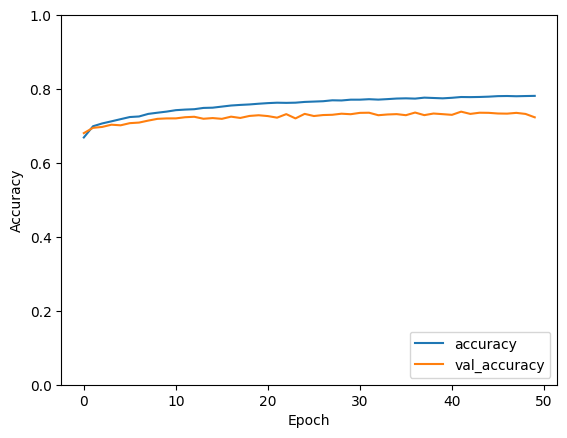

In [20]:
#lets sgraph the learning curve
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')


In [24]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
norm_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)
accuracy = model.evaluate(X_test, y_test)
print('Accuracy:', accuracy)
y_pred = model.predict(X_test)


Epoch 1/50
1501/1501 [==============================] - 8s 5ms/step - loss: nan - accuracy: 0.1758 - val_loss: nan - val_accuracy: 0.1861
Epoch 2/50
1501/1501 [==============================] - 9s 6ms/step - loss: nan - accuracy: 0.1758 - val_loss: nan - val_accuracy: 0.1861
Epoch 3/50
1501/1501 [==============================] - 8s 6ms/step - loss: nan - accuracy: 0.1758 - val_loss: nan - val_accuracy: 0.1861
Epoch 4/50
1501/1501 [==============================] - 8s 6ms/step - loss: nan - accuracy: 0.1758 - val_loss: nan - val_accuracy: 0.1861
Epoch 5/50
1501/1501 [==============================] - 8s 6ms/step - loss: nan - accuracy: 0.1758 - val_loss: nan - val_accuracy: 0.1861
Epoch 6/50
1501/1501 [==============================] - 8s 5ms/step - loss: nan - accuracy: 0.1758 - val_loss: nan - val_accuracy: 0.1861
Epoch 7/50
1501/1501 [==============================] - 8s 5ms/step - loss: nan - accuracy: 0.1758 - val_loss: nan - val_accuracy: 0.1861
Epoch 8/50
1501/1501 [============

In [ ]:
# lets change the credit score column to a 

In [92]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   ID                        100000 non-null  object  
 1   Month                     100000 non-null  object  
 2   Name                      90015 non-null   object  
 3   Age                       100000 non-null  float64 
 4   SSN                       100000 non-null  object  
 5   Annual_Income             100000 non-null  float64 
 6   Monthly_Inhand_Salary     99336 non-null   float64 
 7   Num_Bank_Accounts         100000 non-null  float64 
 8   Num_Credit_Card           100000 non-null  float64 
 9   Interest_Rate             100000 non-null  float64 
 10  Num_of_Loan               100000 non-null  float64 
 11  Delay_from_due_date       100000 non-null  float64 
 12  Num_of_Delayed_Payment    92998 non-null   float64 
 13  Changed_Credit_Limit      1000

In [151]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85763 entries, 0 to 98303
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       85763 non-null  float64
 1   Annual_Income             85763 non-null  float64
 2   Monthly_Inhand_Salary     85763 non-null  float64
 3   Num_Bank_Accounts         85763 non-null  float64
 4   Num_Credit_Card           85763 non-null  float64
 5   Interest_Rate             85763 non-null  float64
 6   Num_of_Loan               85763 non-null  float64
 7   Delay_from_due_date       85763 non-null  float64
 8   Num_of_Delayed_Payment    85763 non-null  float64
 9   Changed_Credit_Limit      85763 non-null  float64
 10  Num_Credit_Inquiries      85763 non-null  float64
 11  Credit_Mix                85763 non-null  int8   
 12  Outstanding_Debt          85763 non-null  float64
 13  Credit_Utilization_Ratio  85763 non-null  float64
 14  Credit_Hist

In [150]:
x = pipeline.fit_transform(train)

Cleaning numeric columns
Transforming Credit_History_Age
Transforming Payment_Behaviour
Transforming Loan Type
Transforming HiLo values
Credit_Mix
Standard    45848
Good        30384
Bad         23768
Name: count, dtype: int64
Occupation
Lawyer           7096
Engineer         6864
Architect        6824
Mechanic         6776
Accountant       6744
Scientist        6744
Developer        6720
Media_Manager    6720
Teacher          6672
Entrepreneur     6648
Doctor           6568
Journalist       6536
Manager          6432
Musician         6352
Writer           6304
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 47 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   Month                     100000 non-null  object  
 1   Age                       100000 non-null  float64 
 2   Annual_Income             100000 non-null  float64 
 3   Monthl

In [152]:
# let get to the model building
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = x.drop(columns=['Credit_Score'])
y = x['Credit_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [153]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8091295983209934


In [18]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=150, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8080802192036378


In [22]:
#okay lets use cross validation to get a better estimate of the model accuracy
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f'Cross Validation Scores: {cv_scores}')
mean_cv_score = cv_scores.mean()
print(f'Mean Cross Validation Score: {mean_cv_score}')


Cross Validation Scores: [0.69509707 0.7033172  0.70401679 0.69222248 0.70481576]
Mean Cross Validation Score: 0.6998938615781062


In [155]:
# lets use startified Kfold to get a better accuracy
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []

for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]
      
      model = RandomForestClassifier(n_estimators=100, random_state=42)
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      accuracy = accuracy_score(y_test, y_pred)
      accuracy_scores.append(accuracy)

print(f'Accuracy Scores: {accuracy_scores}')
print(f'Mean Accuracy: {np.mean(accuracy_scores)}')


Accuracy Scores: [0.8097708855593774, 0.8047571853320119, 0.8080219203637847, 0.8091184701492538, 0.8041627798507462]
Mean Accuracy: 0.8071662482510348


In [ ]:
# Parameter grid for RandomizedSearchCV
param_grid_rf = {
    'n_estimators': [50, 100, 150],           # Number of trees in forest
    'max_depth': [10, 15, 20, None],          # Maximum depth of each tree
    'max_features': ['sqrt', 'log2'],         # Number of features to consider at each split
    'min_samples_split': [2, 5, 10],          # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],            # Minimum samples required at each leaf node
    'bootstrap': [True, False]                # Whether bootstrap samples are used
}

param_grid_et = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 15, 20, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


In [160]:
# Perform RandomizedSearchCV for RandomForest
from sklearn.model_selection import RandomizedSearchCV


start_time = time.time()
rf_random_search = RandomizedSearchCV(
    rf_clf, param_distributions=param_grid_rf, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1
)
rf_random_search.fit(X_train, y_train)
print("RandomForest best params:", rf_random_search.best_params_)
print("Training time for RandomForest:", time.time() - start_time)

# Perform RandomizedSearchCV for ExtraTrees
start_time = time.time()
et_random_search = RandomizedSearchCV(
    et_clf, param_distributions=param_grid_et, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1
)
et_random_search.fit(X_train, y_train)
print("ExtraTrees best params:", et_random_search.best_params_)
print("Training time for ExtraTrees:", time.time() - start_time)


NameError: name 'time' is not defined

In [159]:
#lets do a model with gradient boosting
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train, y_train)
y_pred = gb_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'GradientBoosting Accuracy: {accuracy}')


GradientBoosting Accuracy: 0.7144939365671642


In [25]:
#we usse cross validation and startified kfold on the gradient boosting model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
#import the model 
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(random_state=42)
cv_scores = cross_val_score(gb_clf, X, y, cv=5, scoring='accuracy')
print(f'Cross Validation Scores: {cv_scores}')
mean_cv_score = cv_scores.mean()
print(f'Mean Cross Validation Score: {mean_cv_score}')

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []

for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]
      
      model = GradientBoostingClassifier(random_state=42)
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      accuracy = accuracy_score(y_test, y_pred)
      accuracy_scores.append(accuracy)

print(f'Accuracy Scores: {accuracy_scores}')
print(f'Mean Accuracy: {np.mean(accuracy_scores)}')


Cross Validation Scores: [0.6984201  0.70378359 0.71171224 0.70248368 0.71927472]
Mean Cross Validation Score: 0.707134865719064


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Utilize all available cores
    verbose=2,
    scoring='accuracy'  # Choose appropriate scoring metric
)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:")
print(grid_search.best_params_)

# Best cross-validation score
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_ * 100:.2f}%")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


KeyboardInterrupt: 